## Functions :
-***loadData*** : Load data from csv datasets 

-***visualizeData*** : Have a small insight on the Data

-***Df2Numpy*** : Converts pandas Dataframe to numpy array
***



In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import random 

import itertools


def dataAnalysis(R):
    nUsers = R.shape[0]
    nMovies = R.shape[1]
    
    # Number of rated movies per user
    ratingsPerUser = [sum(R[i, :] > 0) for i in range(nUsers)]
    maxRatingsPerUser = max(ratingsPerUser)
    minRatingsPerUser = min(ratingsPerUser)
    avgRatingsPerUser = sum(ratingsPerUser) / len(ratingsPerUser)
    print("Max ratings per user : ", maxRatingsPerUser)
    print("Min ratings per user : ", minRatingsPerUser)
    print("Avg ratings per user : ", avgRatingsPerUser)
    usersNoRatings = len([u for u in ratingsPerUser if u == 0])
    print("Users with no ratings : ", usersNoRatings)
    
    # Number of ratings per movie
    ratingsPerMovie = [sum(R[:, j] > 0) for j in range(nMovies)]
    maxRatingsPerMovie = max(ratingsPerMovie)
    minRatingsPerMovie = min(ratingsPerMovie)
    avgRatingsPerMovie = sum(ratingsPerMovie) / len(ratingsPerMovie)
    print("Max ratings per movie : ", maxRatingsPerMovie)
    print("Min ratings per movie : ", minRatingsPerMovie)
    print("Avg ratings per movie : ", avgRatingsPerMovie)
    moviesNoRatings = len([m for m in ratingsPerMovie if m == 0])            
    print("Movies with no ratings : ", moviesNoRatings)

def loadData(directory):
    """
        Takes as input the directory of the dataset. 
        Outputs two pandas frames: ratings and movies.
    """
    ratings = pd.read_csv(directory + '/ratings.csv', usecols=['userId', 'movieId', 'rating'])
    movies = pd.read_csv(directory + 'movies.csv')
    return ratings, movies

def visualizeData(ratings, movies):
    print('Ratings is a {} Frame'.format(ratings.shape))
    print(ratings.head())
    print('\n')
    print(ratings.describe())
    print('\n')
    print('Movies is a {} Frame'.format(movies.shape))
    print(movies.head())
    
    nUsers = len(ratings['userId'].unique())
    print("There are {} users in the dataset.".format(nUsers))
    nMovies = len(movies['movieId'].unique())
    print("There are {} movies in the dataset.".format(nMovies))
    
    ratings['rating'].hist(bins=50)
    
def Df2Numpy(ratings):
    ratingsMatrix = ratings.pivot(index='userId', columns='movieId', values='rating')
    ratingsMatrix = ratingsMatrix.fillna(0)
    R = ratingsMatrix.to_numpy()
    return R
    
class MatrixFactorization():
    """
        A Simple Matrix Factorization Class.
        Assumes ratings is a m x n Numpy Array. 
        nFactors is the intermediate dimension k of the Matrices U and V.
        lambdaReg and muReg are regularization parameters.
        Blabla..
    """
    def __init__(self, ratings, nFactors=10, lambdaReg=0.0, muReg=0.0, alpha=0.01, maxIter=100, epsilon=0.001, trainFrac=0.8, valFrac=0.1, testFrac=0.1, mean = 0 , sd=1 ):
        #np.random.seed(0) #Fix seed
        self.R = ratings
        self.nFactors = nFactors
        self.lambdaReg = lambdaReg
        self.muReg = muReg
        self.nUsers, self.nMovies = ratings.shape
        self.alpha = alpha
        self.maxIter = maxIter
        self.U = np.random.normal(size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(size=(self.nMovies, self.nFactors))
        self.samples = self.matrix2Samples(ratings)
        self.epsilon = epsilon
        self.trainFrac = trainFrac
        self.valFrac = valFrac
        self.testFrac = testFrac
        self.mean = mean
        self.sd = sd
        
    def randomInit(self,mean,sd):
        self.U = np.random.normal(loc = mean , scale = sd, size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(loc = mean , scale = sd, size=(self.nMovies, self.nFactors))
        
        
    def NonRandomInit(self):
        self.U = np.ones((self.nUsers, self.nFactors))
        self.V = np.ones((self.nMovies, self.nFactors))
        
    def matrix2Samples(self, R):
        samples = [(i, j, R[i,j]) for i in range(self.nUsers)
           for j in range(self.nMovies) if R[i,j] > 0]
        return samples
    
    def Samples2Matrix(self, samples, m, n):
        matrix = np.zeros(m, n)
        for s in samples:
            i, j, v = s
            matrix[i, j] = v
        return matrix
    
    
    def splitTrainValTest(self):
        # Shuffle the samples and sends back a partition for training, validation and testing
        np.random.shuffle(self.samples)
        nSamples = len(self.samples)
        e1 = math.floor(self.trainFrac * nSamples)
        e2 = math.floor(self.trainFrac * nSamples) + math.floor(self.valFrac * nSamples) 
        
        trainSamples, valSamples, testSamples = self.samples[:e1], self.samples[e1:e2], self.samples[e2:]
        
        # This can be removed if the split is only performed once
        for s in trainSamples:
            i, j, r = s
            R[i, j] = r
        
        for s in valSamples:
            i, j, _ = s
            R[i, j] = 0
            
        for s in testSamples:
            i, j, _ = s
            R[i, j] = 0
            
        # Check if no lost examples
        if nSamples != len(trainSamples) + len(valSamples) + len(testSamples):
            print('ERROR')
        
        return trainSamples, valSamples, testSamples
    
    def splitTrainValSets(self, nGrades=10):
        """
        Split the observed data (nonzero entries) into a training set
        and a validation set by removing 10 grades per user and assigning them
        to the validation set
        """
        valMatrix = np.zeros(self.R.shape)
        trainMatrix = self.R.copy()
        for i in range(self.R.shape[0]):
            valRatingsIds = np.random.choice(self.R[i, :].nonzero()[0],
                                             size=nGrades,
                                             replace=False)
            trainMatrix[i, valRatingsIds] = 0
            valMatrix[i, valRatingsIds] = self.R[i, valRatingsIds]

        assert (np.all(trainMatrix * valMatrix) == 0)
        trainSamples = self.matrix2Samples(trainMatrix)
        valSamples = self.matrix2Samples(valMatrix)
        return trainSamples, valSamples
    
    def trainValTestIdx(self):
        # Returns a partitions of indices 
        nSamples = len(self.samples)
        interval = range(nSamples)
        np.random.shuffle(interval)
        
        e1 = math.floor(self.trainFrac * nSamples)
        e2 = math.floor(self.trainFrac * nSamples) + math.floor(self.valFrac * nSamples) 
        
        trainIdx, valIdx, testIdx = interval[:e1], interval[e1:e2], interval[e2:]
        
        # Check if no lost examples
        if nSamples != len(trainSamples) + len(valSamples) + len(testSamples):
            print('ERROR')
        
        return trainIdx, valIdx, testIdx
    
    #def stochasticGradientDescentPass(self, R, U, V, alpha, lambdaReg, muReg, nFactors):
    #    for i in range(R.shape[0]):
    #        for j in range(R.shape[1]):
    #            if R[i, j] > 0:
    #                r_hat_ij = np.dot(U[i, :], V.T[:, j])
    #                eij = R[i, j] - r_hat_ij
    #                for q in range(nFactors):
    #                    U[i, q] = U[i, q] + alpha * (eij * V[j, q] - lambdaReg * U[i, q])
    #                    V[j, q] = V[j, q] + alpha * (eij * U[i, q] - muReg * V[j, q])
    #    return U, V

    def stochasticGradientDescentPass(self, trainSamples):
        for s in trainSamples:
            i, j, _ = s
            r_hat_ij = np.dot(self.U[i, :], self.V.T[:, j])
            eij = self.R[i, j] - r_hat_ij
            tmpU = np.zeros(self.nFactors)
            tmpV = np.zeros(self.nFactors)
            for q in range(self.nFactors):
                tmpU[q] = self.U[i, q] + self.alpha * (eij * self.V[j, q] - self.lambdaReg * self.U[i, q])
                tmpV[q] = self.V[j, q] + self.alpha * (eij * self.U[i, q] - self.muReg * self.V[j, q])
            
            self.U[i, :] = tmpU[:]
            self.V[j, :] = tmpV[:]
            
        return self.U, self.V

    def gridSearch(self, factors, alphas, lambdaRegs, muRegs):
        lowest_error = math.inf
        best_config = None
        bestSolution = (None, None)
        for config in itertools.product(factors, alphas, lambdaRegs, muRegs):
            self.nFactors, self.alpha, self.lambdaReg, self.muReg = config
            U, V, history = self.stochasticGradientDescent(False)
            if history['valError'] < lowest_error:
                lowest_error = history['valError']
                best_config = config
                bestSolution = (U, V)
                
        self.U, self.V = bestSolution    # Just for consistency 
        
        return U, V, best_config
            
            
    def stochasticGradientDescent(self, logging=True):
        history = {'trainErrors':[], 'valErrors':[]}
        self.randomInit(mean = self.mean, sd = self.sd)
        #self.NonRandomInit()
        trainSamples, valSamples, testSamples = self.splitTrainValTest()  # This should probably be outside ?
        for i in range(self.maxIter):
            # I think we should shuffle the data here. 
            np.random.shuffle(trainSamples)
            U, V = self.stochasticGradientDescentPass(trainSamples)
            trainError = self.computeTotalErrorSamples(trainSamples)
            
            if logging:
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            if trainError < self.epsilon:
                break
        
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return U, V, history


    def computeTotalErrorSamples(self, data):
        error = 0
        if len(data) == 0:
            return 0
        for s in data:
            i, j, r = s
            error += (r - np.dot(self.U[i, :], self.V.T[:, j])) ** 2
        return error / len(data)

    def plotHistory(self, history): 
        plt.plot(history['trainErrors'], label='Training Error')
        plt.plot(history['valErrors'], label='Validation Error')
        plt.title('Evolution of the Loss')
        plt.ylabel('Loss Func')
        plt.xlabel('Iteration')
        plt.legend()
        plt.show()
        
    def computeApproximatedMatrix(self, U, V):
        return np.dot(U, V.T)
    
    def alsIteration(self, R, fixedVectors, solveVectors, regParameter):
        A = np.dot(fixedVectors.T,
                   fixedVectors) + np.eye(self.nFactors) * regParameter
        b = np.dot(R, fixedVectors)
        A_inv = np.linalg.inv(A)
        solveVectors = b.dot(A_inv)
        return solveVectors
    
    def alsUserStep(self, i):
        u = np.dot(
            np.linalg.inv(sum([np.outer(self.V[j, :], self.V[j, :]) 
                            for j in range(self.nMovies) if self.R[i, j] > 0]) + 
                               self.lambdaReg * np.eye(self.nFactors)), 
            sum([self.R[i,j] * self.V[j, :] for j in range(self.nMovies) if self.R[i, j] > 0])
        )
        return u
    
    def alsMovieStep(self, j):
        #try: 
        v = np.dot(
        np.linalg.inv(sum([np.outer(self.U[i, :], self.U[i, :]) 
                            for i in range(self.nUsers) if self.R[i, j] > 0]) +
                               self.muReg * np.eye(self.nFactors)), 
        sum([self.R[i,j] * self.U[i, :] for i in range(self.nUsers) if self.R[i, j] > 0])
        )
        #except :
        #    break
        return v
    
    def alsIterationNew(self):
        tmpU = np.zeros((self.nUsers, self.nFactors))
        tmpV = np.zeros((self.nMovies, self.nFactors))
        for i in range(self.nUsers):
            if any([self.R[i, j] > 0 for j in range(self.nMovies)]):
                tmpU[i, :] = self.alsUserStep(i)
        
        self.U = tmpU
        for j in range(self.nMovies):
            if any([self.R[i, j] > 0 for i in range(self.nUsers)]):
                tmpV[j, :] = self.alsMovieStep(j)
            
        self.V = tmpV
        
    def als(self, logging=True):
        history = {'trainErrors': [], 'valErrors': []}
        self.randomInit(self.mean, self.sd)
        trainSamples, valSamples, testSamples = self.splitTrainValTest()
        
        for i in range(self.maxIter):
            #np.random.shuffle(trainSamples)
            self.alsIterationNew()
            
            trainError = self.computeTotalErrorSamples(trainSamples)
            if logging:
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            if trainError < self.epsilon:
                break
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return self.U, self.V, history

    def alsFit(self, logging=True):
        history = {'trainErrors': [], 'valErrors': []}
        self.randomInit()
        trainSamples, valSamples, testSamples = self.splitTrainValTest()
        for i in range(self.maxIter):
            np.random.shuffle(trainSamples)
            self.U = self.alsIteration(self.R, self.V, self.U, self.lambdaReg)
            self.V = self.alsIteration(self.R.T, self.U, self.V, self.muReg)
            trainError = self.computeTotalErrorSamples(trainSamples)

            if logging:
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            if trainError < self.epsilon:
                break
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return self.U, self.V, history
    
# Generates a rank(k) matrix. Should add some noise..    
def syntheticMatrix(m, n, k):
    basis = np.random.randint(3, size=(m, k))
    matrix = np.zeros((m, n))
    coeffs = np.random.randint(3, size=k)
    
    for i in range(n):
        coeffs = np.random.randint(4, size=k)
        matrix[:, i] = sum([coeffs[j] * basis[:, j] for j in range(k)]) # TODO: + some small noise vector
         
    return matrix
    

Ratings is a (100836, 3) Frame
   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


              userId        movieId         rating
count  100836.000000  100836.000000  100836.000000
mean      326.127564   19435.295718       3.501557
std       182.618491   35530.987199       1.042529
min         1.000000       1.000000       0.500000
25%       177.000000    1199.000000       3.000000
50%       325.000000    2991.000000       3.500000
75%       477.000000    8122.000000       4.000000
max       610.000000  193609.000000       5.000000


Movies is a (9742, 3) Frame
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

               

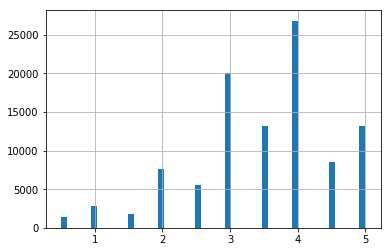

In [42]:
ratings, movies = loadData('Data/')
visualizeData(ratings, movies)

(1, 0.0001, 0.01, 0.01)


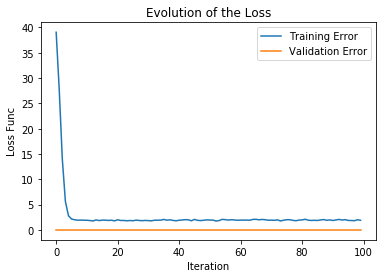

In [13]:

mf = MatrixFactorization(R, nFactors=3, lambdaReg=1.0, muReg=1.0, trainFrac=1.0, valFrac=0.0, testFrac=0.0)
U, V, best_config = mf.gridSearch(factors=[1, 3, 5, 10], alphas=[0.0001, 0.001, 0.01], lambdaRegs=[0.01, 0.1, 1.0], muRegs=[0.01, 0.1, 1.0])
print(best_config)
U, V, history = mf.stochasticGradientDescent(True)
mf.plotHistory(history)

In [43]:
#R = np.array([
#    [5, 3, 0, 1],
#    [4, 0, 0, 1],
#    [1, 1, 0, 5],
#    [1, 0, 0, 4],
#    [0, 1, 5, 4],
#])
#R = syntheticMatrix(20, 8, 3)
R = Df2Numpy(ratings)

In [4]:
mf = MatrixFactorization(R, nFactors=2, lambdaReg=0.01, muReg=0.01, alpha=0.01, trainFrac=0.8, valFrac=0.2, testFrac=0.0, maxIter=10, mean = 1 , sd = 0.1)

In [5]:
U, V, history = mf.stochasticGradientDescent(True)

In [6]:
np.dot(U, V.T)

array([[4.49200242, 4.13940747, 3.8655823 , ..., 3.67074053, 3.75787645,
        4.23698943],
       [3.82249402, 3.52299752, 3.28950018, ..., 3.12492308, 3.19745795,
        3.60688668],
       [2.74378466, 2.53673677, 2.3620991 , ..., 2.26174929, 2.29037701,
        2.60931451],
       ...,
       [3.45782428, 3.15389448, 2.97194459, ..., 2.74905646, 2.91221505,
        3.17833161],
       [3.47441031, 3.21848605, 2.99179591, ..., 2.87875562, 2.89651427,
        3.32014368],
       [4.05852367, 3.7924859 , 3.49849619, ..., 3.44025406, 3.36373076,
        3.96253735]])

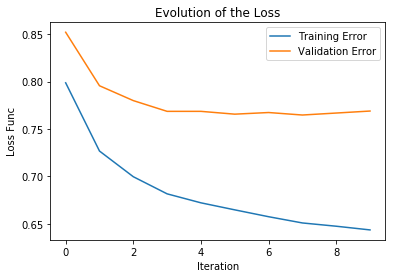

Training error :  0.6436726178725659
Validation error :  0.7689557698806098


In [7]:
mf.plotHistory(history)
print("Training error : ", history['trainError'])
print("Validation error : ", history['valError'])

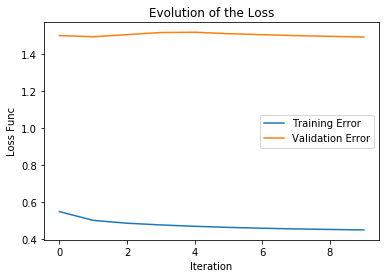

Training error :  0.44968146762269606
Validation error :  1.4911419058866917


In [18]:
#R = syntheticMatrix(20, 8, 4)
#print(R)

R = Df2Numpy(ratings)
mf = MatrixFactorization(R, nFactors=3, lambdaReg=0.1, muReg=0.1, alpha=0.01, trainFrac=0.8, valFrac=0.2, testFrac=0.0, maxIter=10, mean = 1, sd = 0.01)
U, V, history = mf.als()

mf.plotHistory(history)
print("Training error : ", history['trainError'])
print("Validation error : ", history['valError'])


#print(np.dot(U, V.T))
#print(R)

In [2]:
import numpy as np

In [14]:
import progressbar

In [ ]:
train_err=[]
val_err =[]
pb = progressbar.ProgressBar(max_value = 12)
pb.start()
for k in range(1,12):
    R = Df2Numpy(ratings)
    mf = MatrixFactorization(R, nFactors=k, lambdaReg=0.1, muReg=0.1, alpha=0.01,trainFrac=0.8, valFrac=0.2, testFrac=0.0,maxIter=30, mean =1 ,sd = 0.1)
    #U, V, history = mf.als(True)
    U, V, history = mf.stochasticGradientDescent(True)
    #mf.plotHistory(history)
    train_err.append(history['trainError'])
    val_err.append(history['valError'])
    pb.update(pb.value+1)
print(train_err,val_err)
plt.plot(range(1,12), train_err)
plt.plot(range(1,12), val_err)

 83% (10 of 12) |####################    | Elapsed Time: 0:10:35 ETA:   0:03:10

In [49]:
R = Df2Numpy(ratings)
mf = MatrixFactorization(R, nFactors=4, lambdaReg=0.1, muReg=0.1, alpha=0.01,trainFrac=0.8, valFrac=0.2, testFrac=0.0,maxIter=5, mean =1 ,sd = 0.1)
U, V, history = mf.stochasticGradientDescent(True)
print(history['trainError'])
print(history['valError'])

0.6972893271922261
0.7880399863834019


In [45]:
def best_initialization(mean, sd):
    lowest_error = math.inf
    best_init = None
    bestUV = (None,None)
    errors = []
    for config in itertools.product(mean, sd):
        mean, sd = config
        R = Df2Numpy(ratings)
        mf = MatrixFactorization(R, nFactors=3, lambdaReg=0.1, muReg=0.1, alpha=0.01, trainFrac=0.8, valFrac=0.2, testFrac=0.0, maxIter=5, mean = mean , sd=sd)
        #U, V, history = mf.stochasticGradientDescent(True)
        U, V, history = mf.als(True)
        print(history['valError'])
        errors.append(history['valError'])
        if history['valError'] < lowest_error:
            lowest_error = history['valError']
            best_init = config
            bestUV = U,V
    return U,V,lowest_error, best_init, errors

In [ ]:
#best_initialization([-5,-4,-3,-2,-1,0,1,2,3,4,5],[0.5])

0.49123820898993686
0.49829598948087783
0.4920813984697845
0.4746826859591383


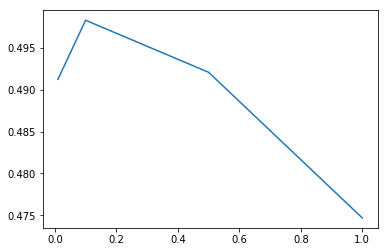

In [46]:
d = best_initialization([1],[0.01,0.1,0.5,1])[4]
plt.plot([0.01,0.1,0.5,1],d)

#ALS VALIDATION ERROR EN FONCTION DE STANDARD DEVIATION A MEAN=1 

In [9]:
def plot_best_init(mean):
    d = best_initialization([mean],[0.01,0.1,0.2,0.3,0.4,0.5,0.7,1])[4]
    plt.plot([0.01,0.1,0.2,0.3,0.4,0.5,0.7,1], d)

1.3090499006414436
1.2805005340299587
1.2758938337093702
1.2771303170568933
1.3686500065377503
1.3155144711533049
1.372378809105249
1.410437373536466
1.5862473763684974
0.7711914406797539
0.7862747024024728
0.7820779836865048
0.7917221291560071
0.7951768139542993
0.8196293993025917
0.8316698495590706
0.875150309065631
0.9741709365111312
0.8903521528921858
0.9161713552224857
0.8671264253828596
0.8915230831916717
0.9012252717250566
0.9231883191425806
0.9222777400237846
0.9566885094805934
1.0324153561276432
1.1297095630339913
0.9607848653985366
0.9387317469318417
0.8957660435594066
0.9456939782596607
0.9373621155047897
0.9409366577275811
1.1049537105735687
1.1760638076587895


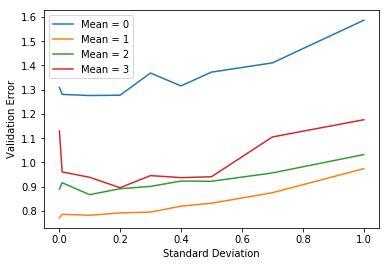

In [10]:
plt.xlabel("Standard Deviation")
plt.ylabel("Validation Error")
d = best_initialization([0],[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1])[4]
plt.plot([0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1], d, label="Mean = 0")
d = best_initialization([1],[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1])[4]
plt.plot([0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1], d, label="Mean = 1")
d = best_initialization([2],[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1])[4]
plt.plot([0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1], d, label="Mean = 2")
d = best_initialization([3],[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1])[4]
plt.plot([0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1], d,label="Mean = 3")
plt.legend()
plt.show()